In [1]:
# Load standard modules
import os
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta
import xarray as xr
import zarr
import cmocean as cm

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# cuda setup, set seed for reproducability 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(41)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device: {device}")


# YOU NEED THIS TO LOAD PyTorch Lightning I DON"T KNOW WHY

from jupyter_client.manager import KernelManager

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Set torch dtype to float64
torch.set_default_dtype(torch.float64)

# Set model path
import sys
sys.path.append('./src/')
import simvip_model
import data_loaders



Using device: cpu


/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniforge3/envs/swot_python12_pytorch/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
np.gradient(np.gradient(np.array([[1, 2, 6], [3, 4, 5], [3, 4, 5]]), axis=0),axis=0)

array([[-1. , -1. ,  0.5],
       [-1. , -1. ,  0.5],
       [-1. , -1. ,  0.5]])

In [3]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

In [4]:
os.cpu_count()

48

In [5]:
print(torch.version.cuda)

12.4


In [6]:
torch.get_num_threads()

8

In [7]:
from importlib import reload
simvip_model = reload(simvip_model)
data_loaders = reload(data_loaders)

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#SimVip_model = simvip_model.SimVP_Model_no_skip_sst(in_shape=(30,2,128,128)).to(device)
device

'cpu'

# Define the dataloaders

In [9]:
######################################################################################################
######################################################################################################
# Modules for loading data, set data pathimport urllib
DATASET_PATH = '/home/tm3076/scratch/pytorch_learning_tiles'
CHECKPOINT_PATH = '/home/tm3076/scratch/tm3076/pytorch_training'
DRIVE_PATH = "."

n_cpus = 0# torch.get_num_threads()#os.cpu_count()
mid_timestep = 100
N_t = 20
#pre-computed global normalisation stats
mean_ssh = 0.074
std_ssh = 0.0986
mean_sst = 293.307
std_sst = 8.726 

# Lambda transforms to apply to input fields
std_ssh_norm = lambda x: x/std_ssh
std_sst_norm = lambda x: x/std_sst
std_sst_norm = lambda x: (x-mean_sst)/std_sst
no_transform = lambda x: x

infields = ["zarr_llc4320_SSH_tiles_4km_filtered","zarr_llc4320_SST_tiles_4km"]
outfields = ["zarr_llc4320_SSH_tiles_4km_filtered"]
in_mask_list = ["swot",None]
out_mask_list = [None]
in_transform_list = [std_ssh_norm,std_sst_norm]
out_transform_list = [std_ssh_norm]

#patch_coords = np.load(f'{DATASET_PATH}/np_SST_masks/x_y_coordinates.npy')
patch_coords = zarr.load(f'{DATASET_PATH}/x_y_coordinates_noland.zarr')
batch_size = 5

multiprocessing = False


# Data loader 
full_dataset = torch.utils.data.ConcatDataset([data_loaders.llc4320_dataset(DATASET_PATH, i_mid_timestep, N_t, patch_coords, 
                                                                            infields, outfields, in_mask_list, out_mask_list, 
                                                                            in_transform_list, out_transform_list, 
                                                                            multiprocessing = multiprocessing
                                                                           ) for i_mid_timestep in range(30,360,5)])


In [10]:
print(f"size full_dataset: {len(full_dataset)}")

# Split into train, validation, and test data
train_length = int(0.7*len(full_dataset))
validation_length = int(0.2*len(full_dataset))
test_length = len(full_dataset) - train_length - validation_length
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, (train_length, validation_length, test_length))

# Verify size of datasets
print(f"size train_dataset: {len(train_dataset)}")
print(f"size validation_dataset: {len(validation_dataset)}")
print(f"size test_dataset: {len(test_dataset)}")

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)
val_data_loader   = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)
test_data_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = worker_init_fn, persistent_workers=multiprocessing)


size full_dataset: 23826
size train_dataset: 16678
size validation_dataset: 4765
size test_dataset: 2383


In [11]:
for step, (x, y, metadata) in enumerate(test_data_loader):
    print(step)
    break
    

0


In [12]:
print("x.shape",x.shape)
print("y.shape",y.shape)

x.shape torch.Size([5, 20, 2, 128, 128])
y.shape torch.Size([5, 20, 1, 128, 128])


In [13]:
metadata

{'patch_ID': ['203', '338', '124', '024', '290'],
 'mid_timestep': tensor([ 55, 155, 325, 115, 170]),
 'patch_coords': tensor([[-158.0000,   47.0000,  203.0000],
         [-156.5000,   39.5000,  338.0000],
         [-161.0000,   38.0000,  124.0000],
         [-128.0000,   26.0000,   24.0000],
         [-141.5000,   33.5000,  290.0000]]),
 'latitude': tensor([[[44.6525, 44.6539, 44.6553,  ..., 44.6553, 44.6539, 44.6525],
          [44.6886, 44.6901, 44.6915,  ..., 44.6915, 44.6901, 44.6886],
          [44.7248, 44.7262, 44.7276,  ..., 44.7276, 44.7262, 44.7248],
          ...,
          [49.1754, 49.1770, 49.1787,  ..., 49.1787, 49.1770, 49.1754],
          [49.2115, 49.2132, 49.2148,  ..., 49.2148, 49.2132, 49.2115],
          [49.2476, 49.2493, 49.2509,  ..., 49.2509, 49.2493, 49.2476]],
 
         [[37.1600, 37.1611, 37.1622,  ..., 37.1622, 37.1611, 37.1600],
          [37.1962, 37.1973, 37.1984,  ..., 37.1984, 37.1973, 37.1962],
          [37.2325, 37.2336, 37.2346,  ..., 37.2346, 3

## Verify Dataloader is working as expected

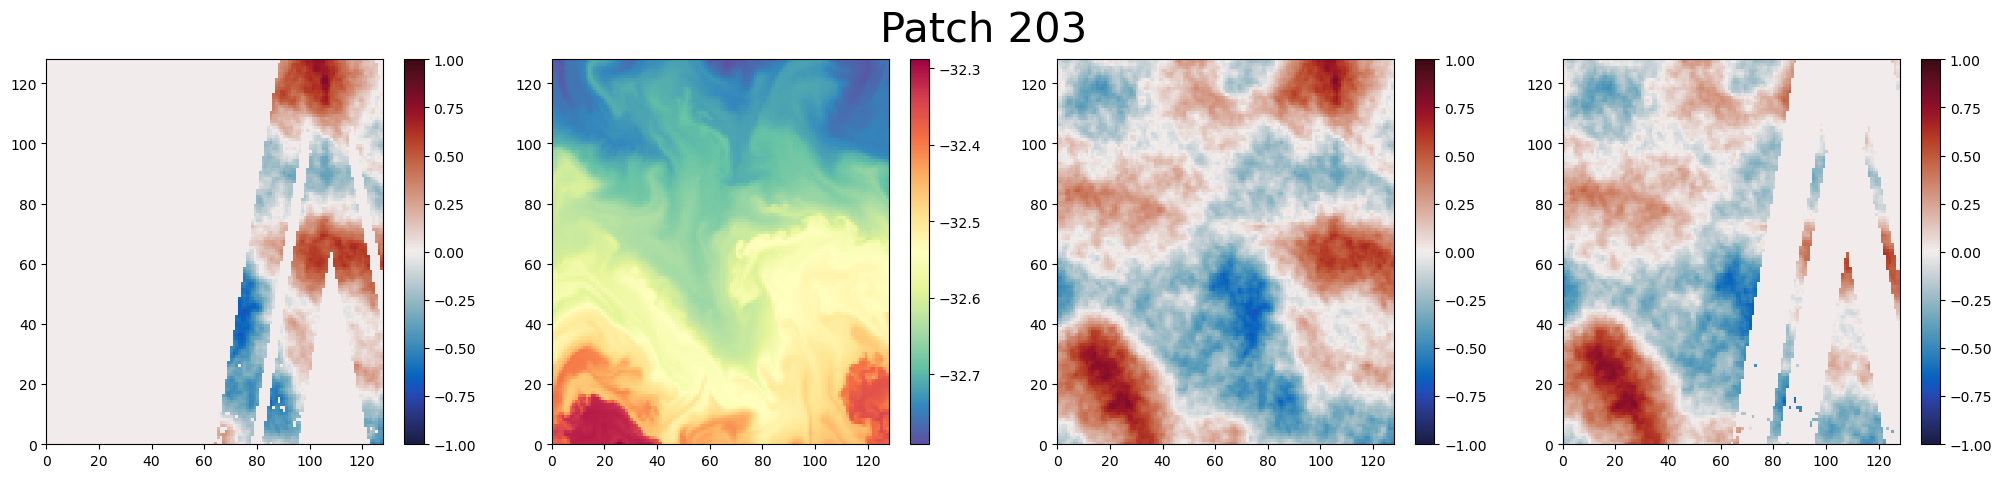

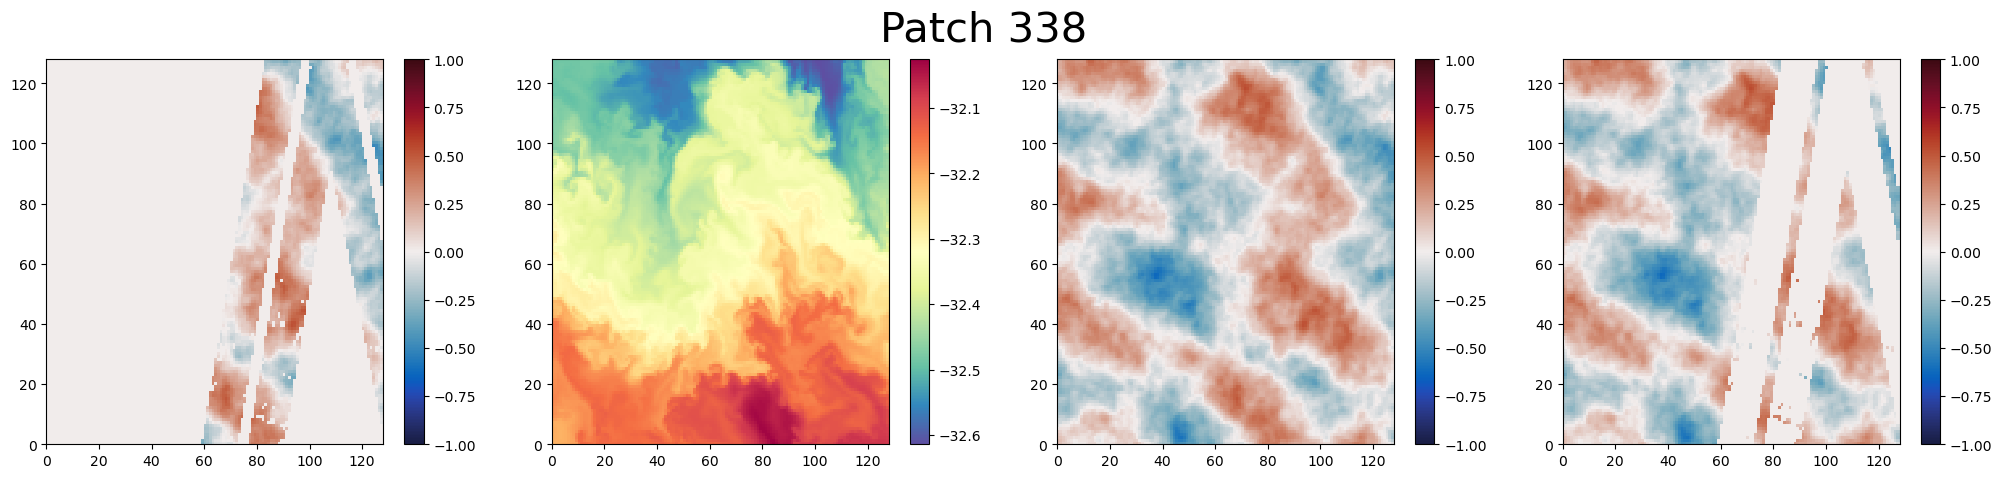

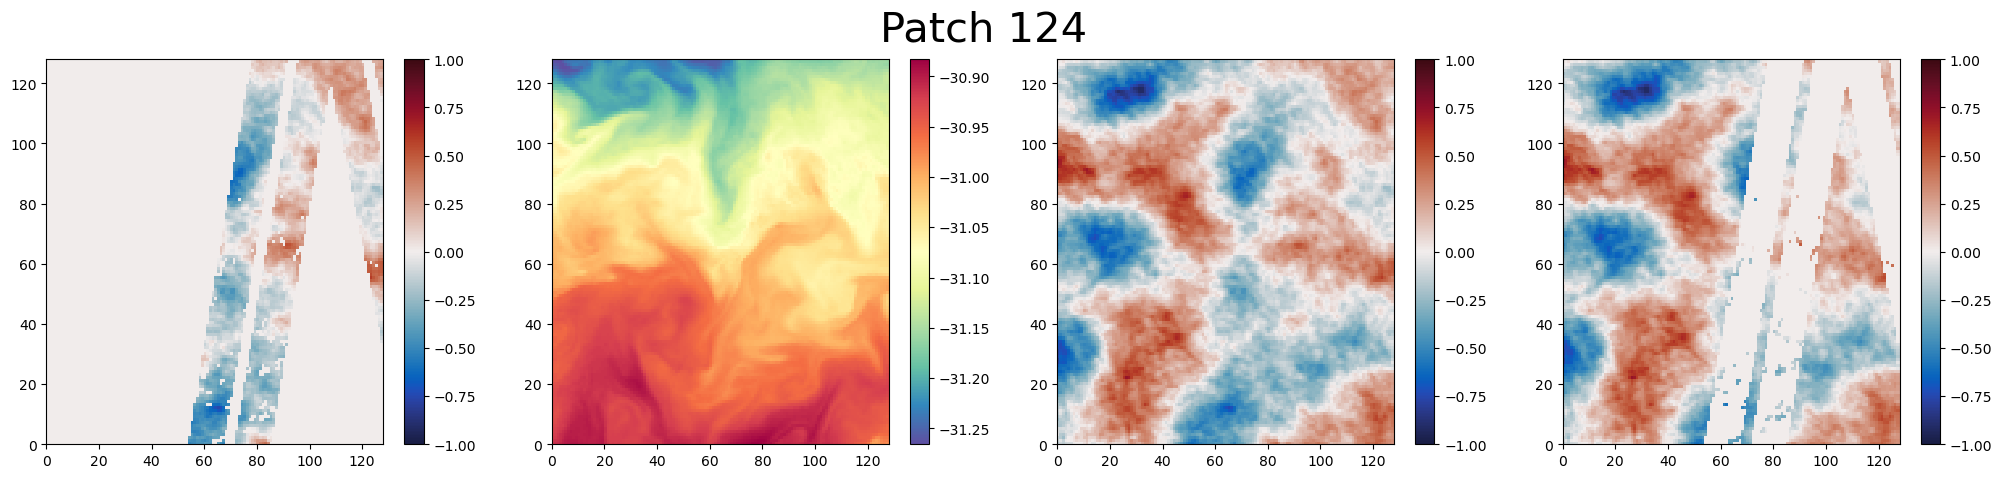

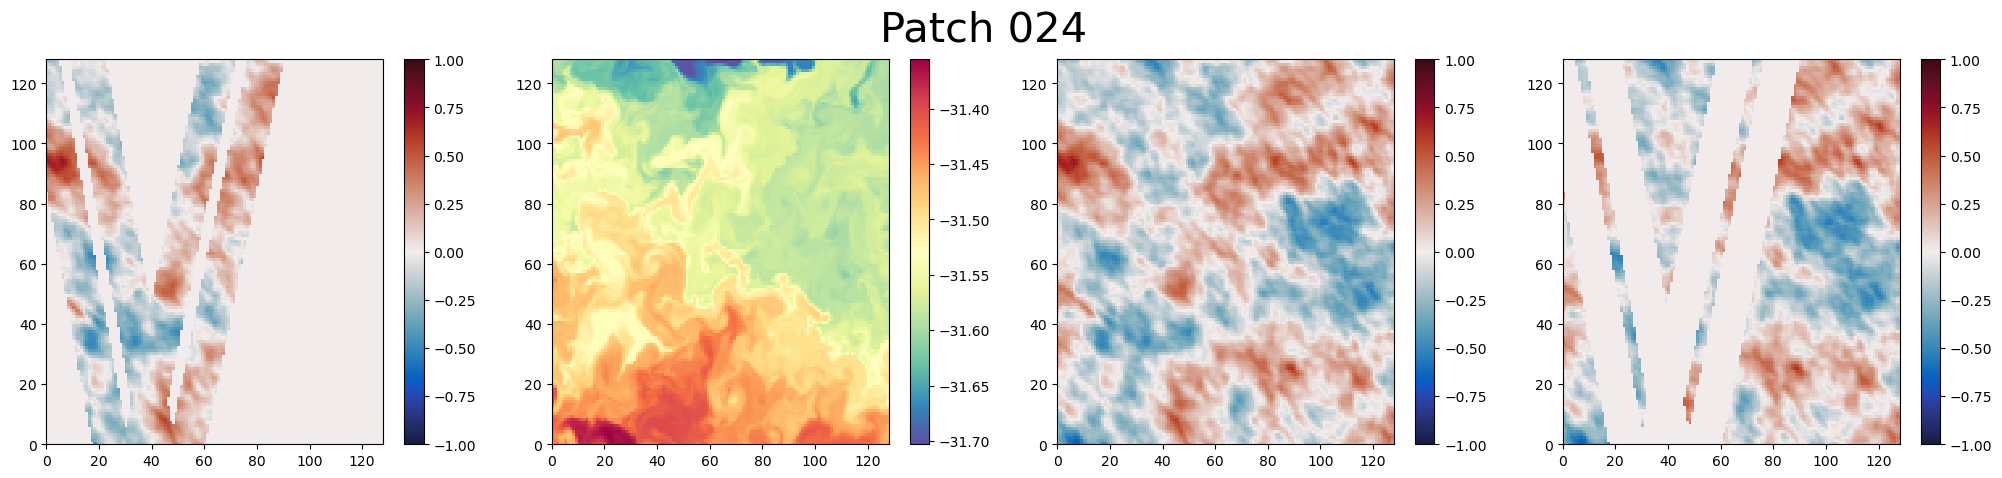

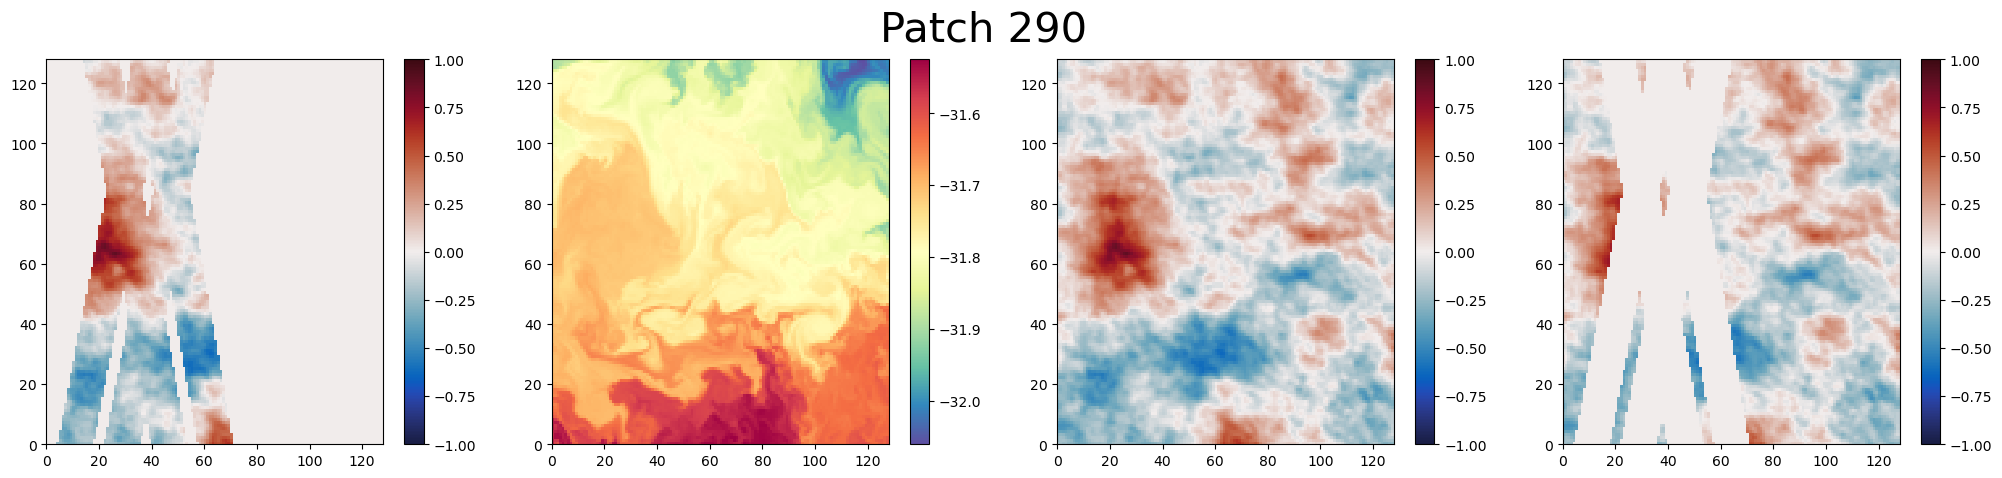

In [14]:
for i in range(len(x)):
    fig, axs = plt.subplots(1,4,figsize=(25,5))
    ims = [axs[0].pcolor(x[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[1].pcolor(x[i,10,1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[3].pcolor(y[i,10,0,:,:]-x[i,10,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1)]
    for j, im in enumerate(ims):
        fig.colorbar(im,ax=axs[j])
    fig.suptitle(f"Patch {metadata["patch_ID"][i]}",fontsize=30)
    plt.show()
    plt.close()
    

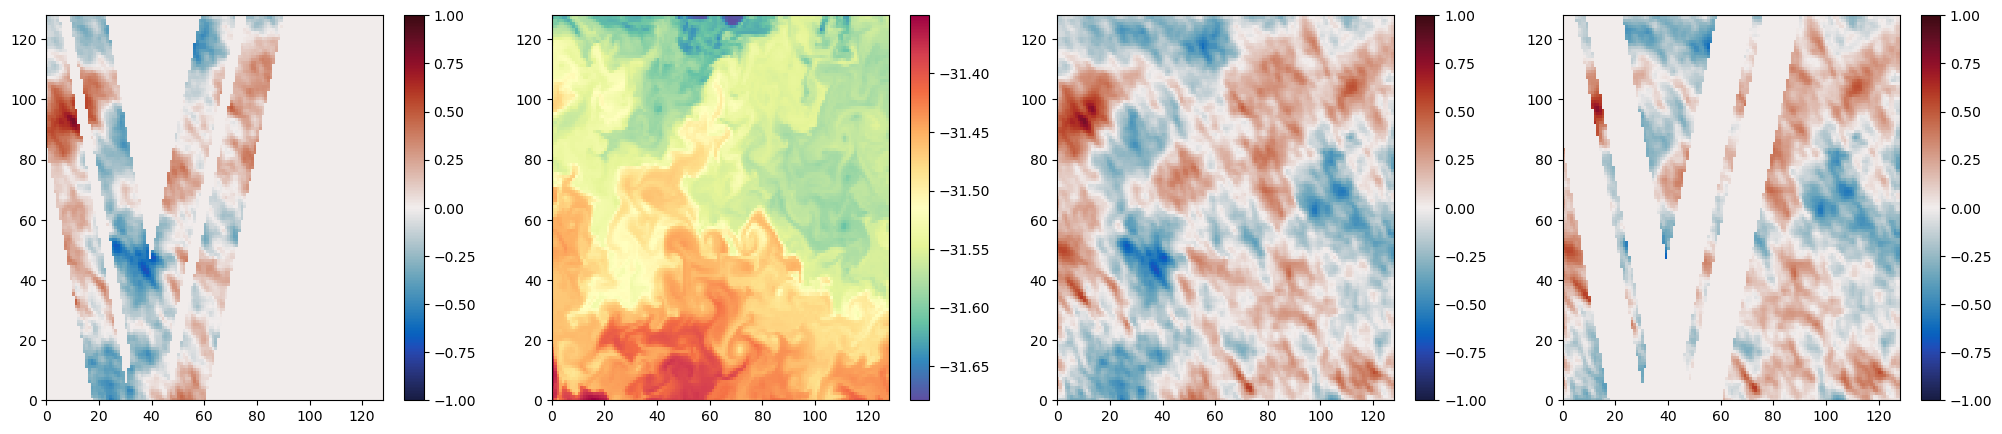

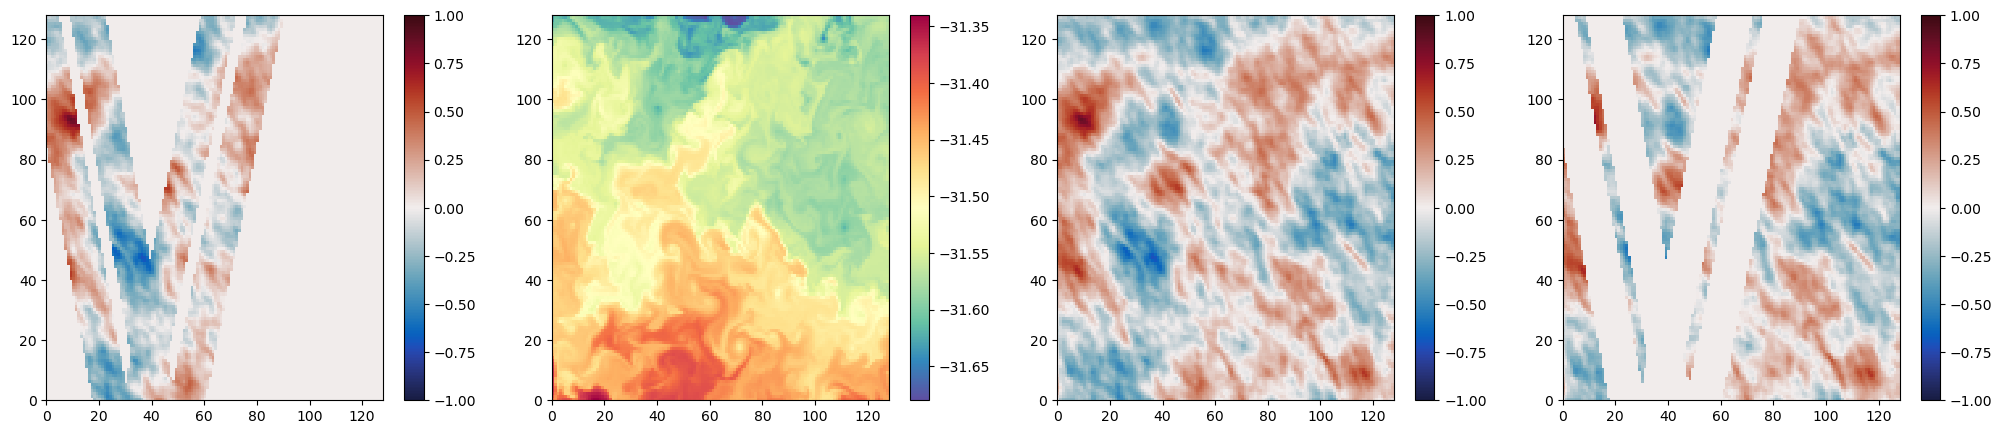

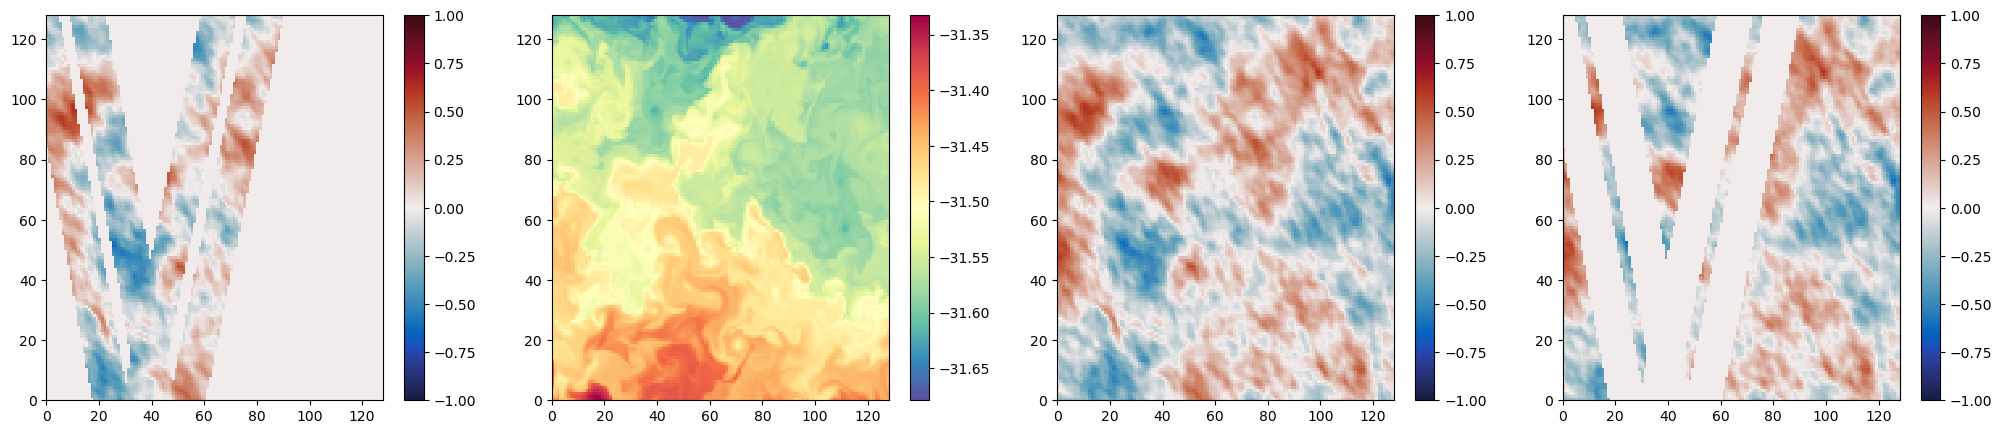

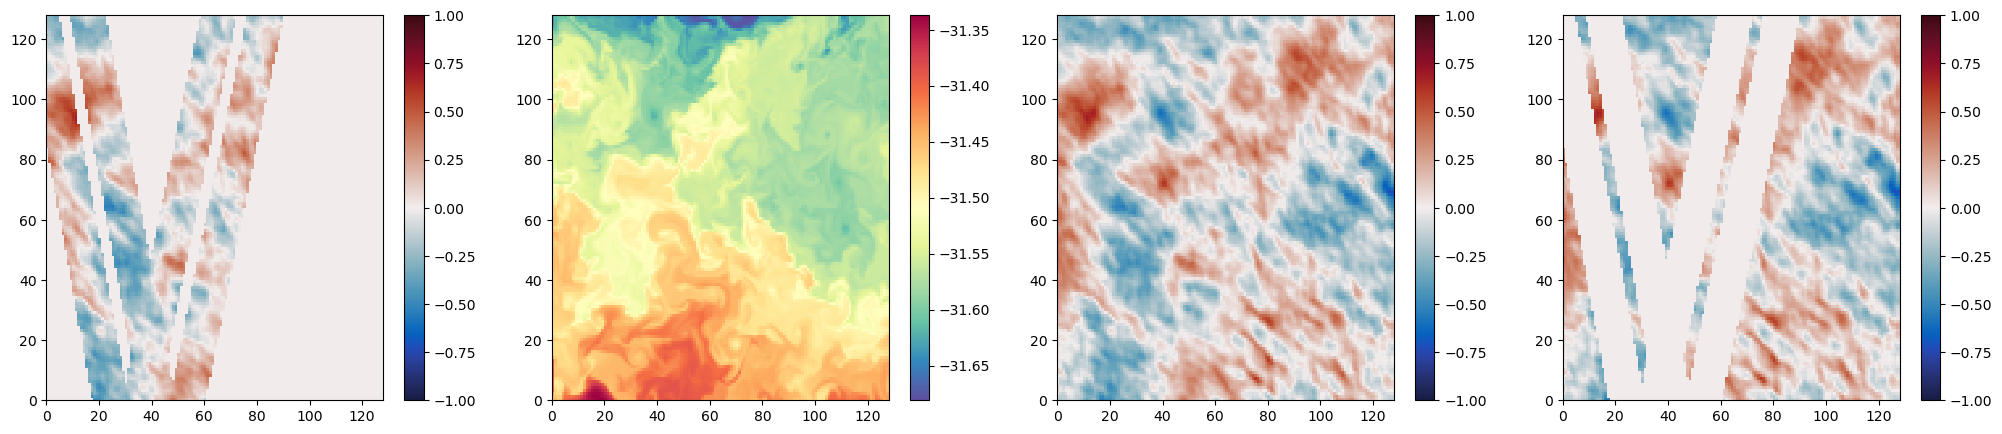

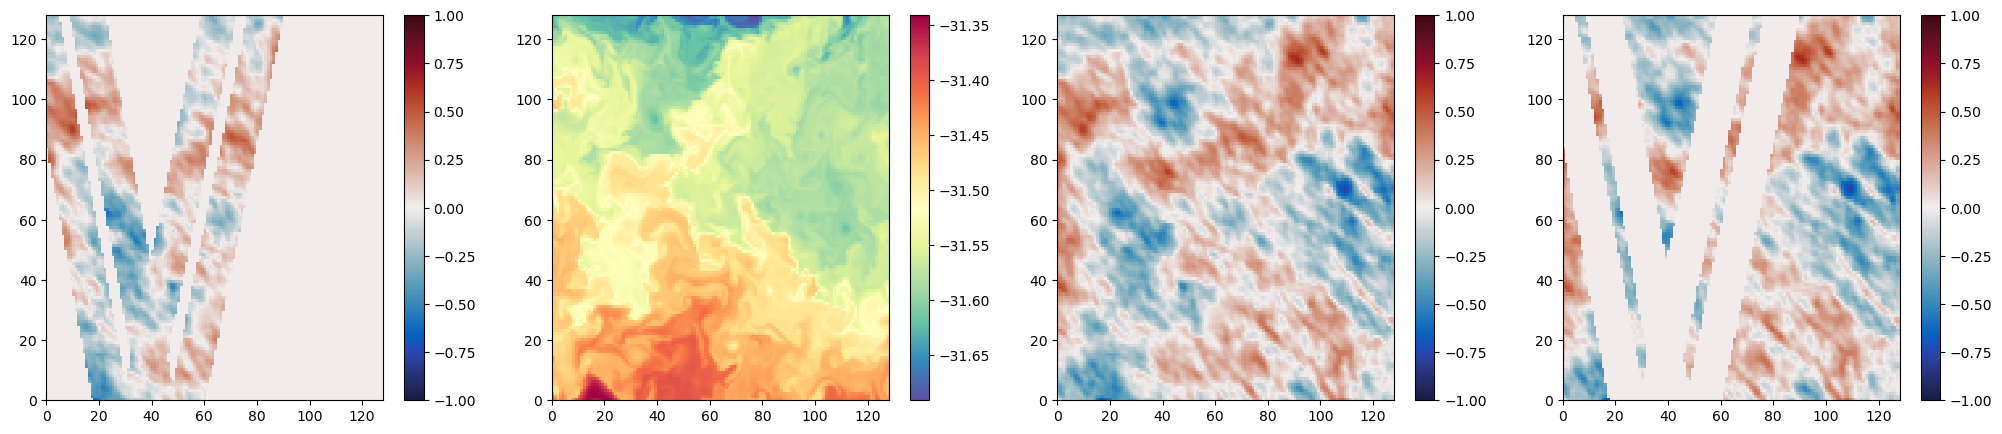

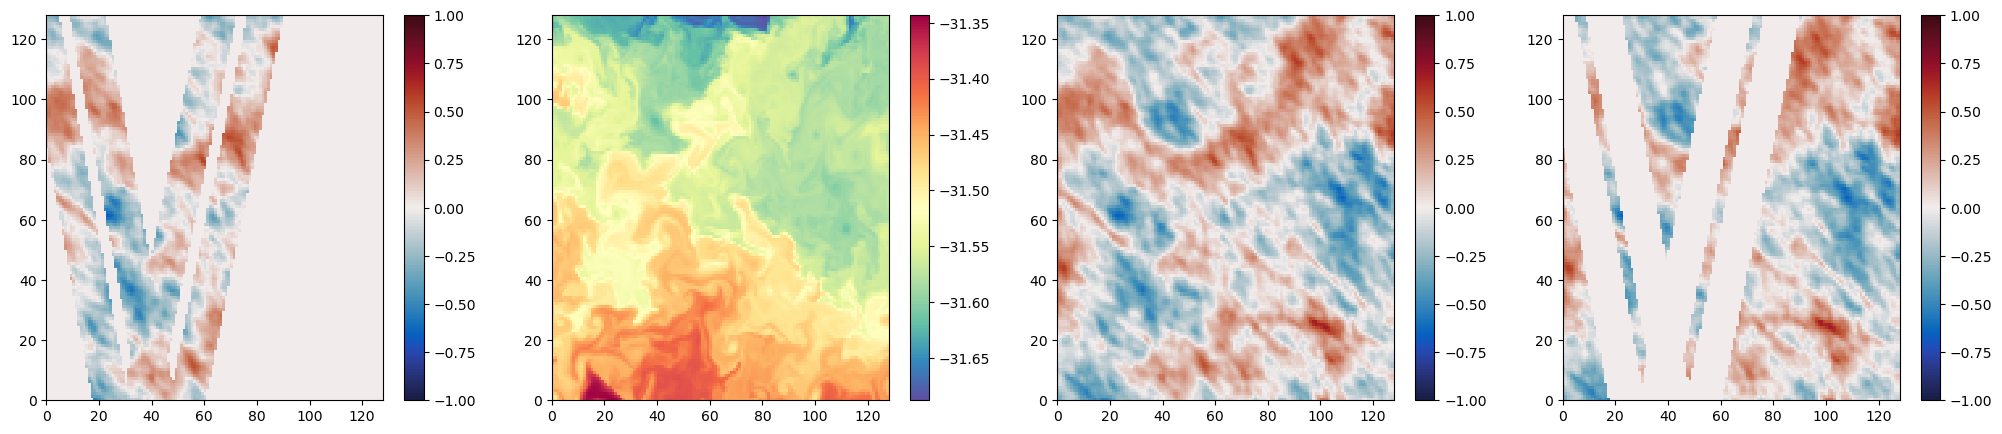

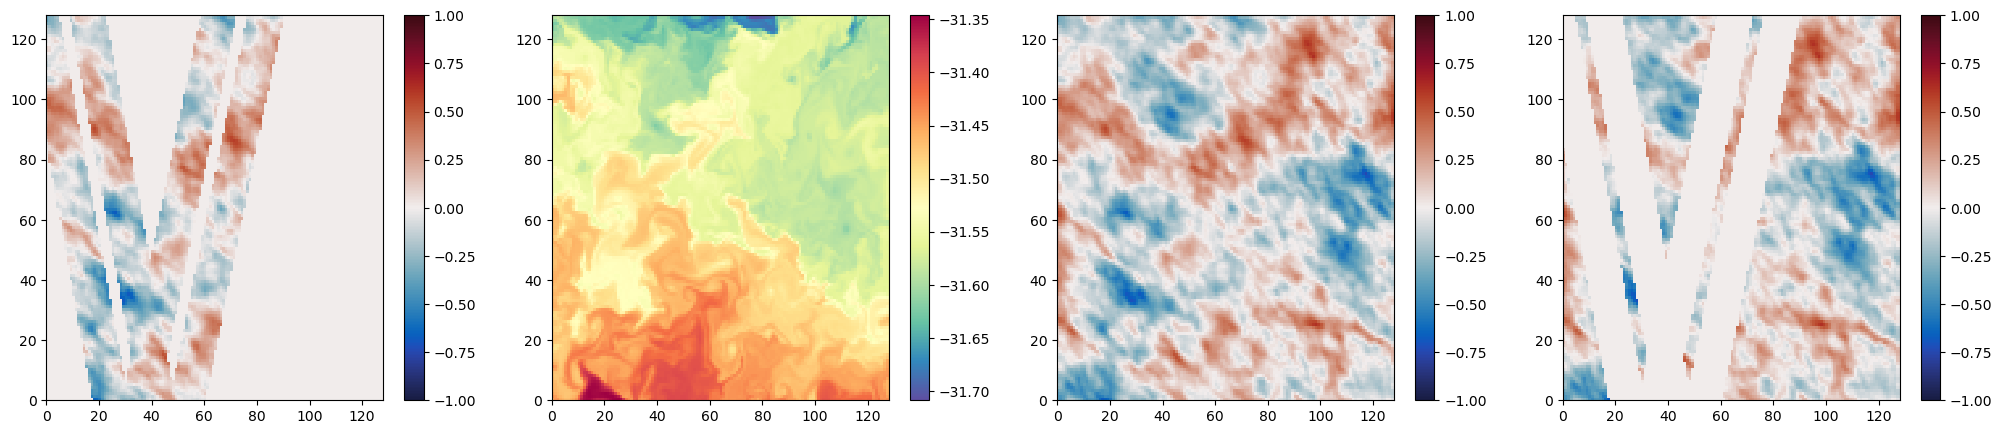

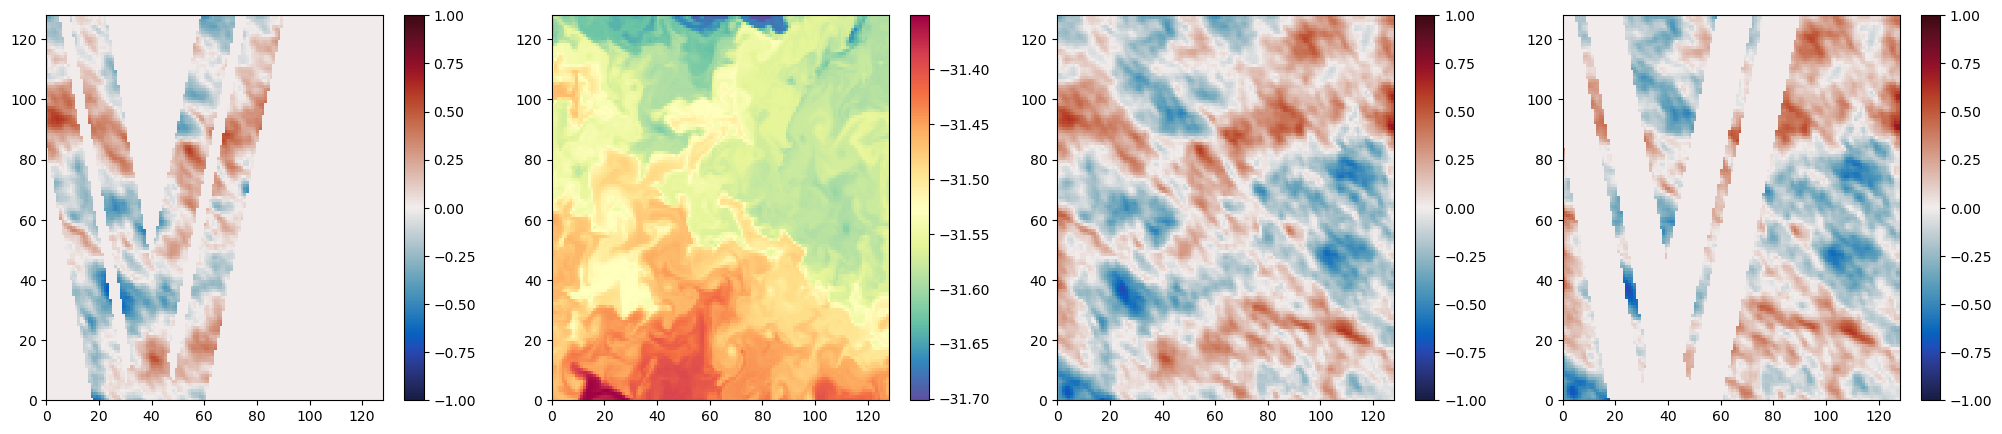

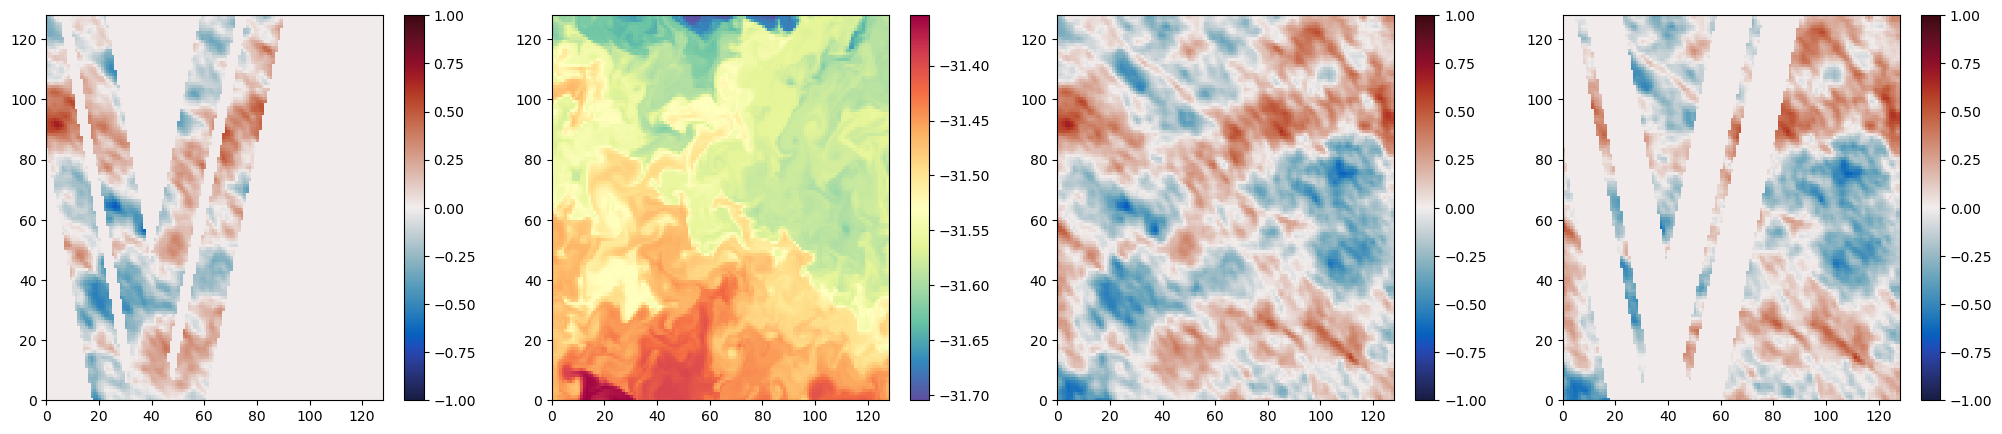

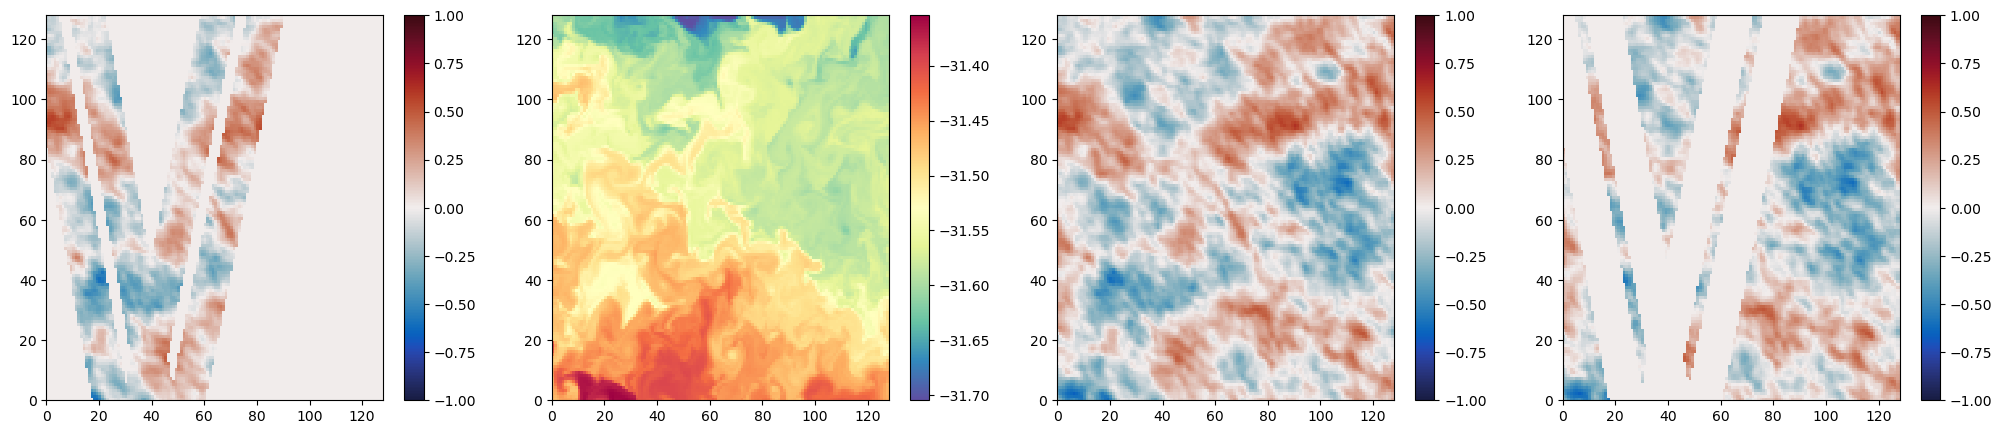

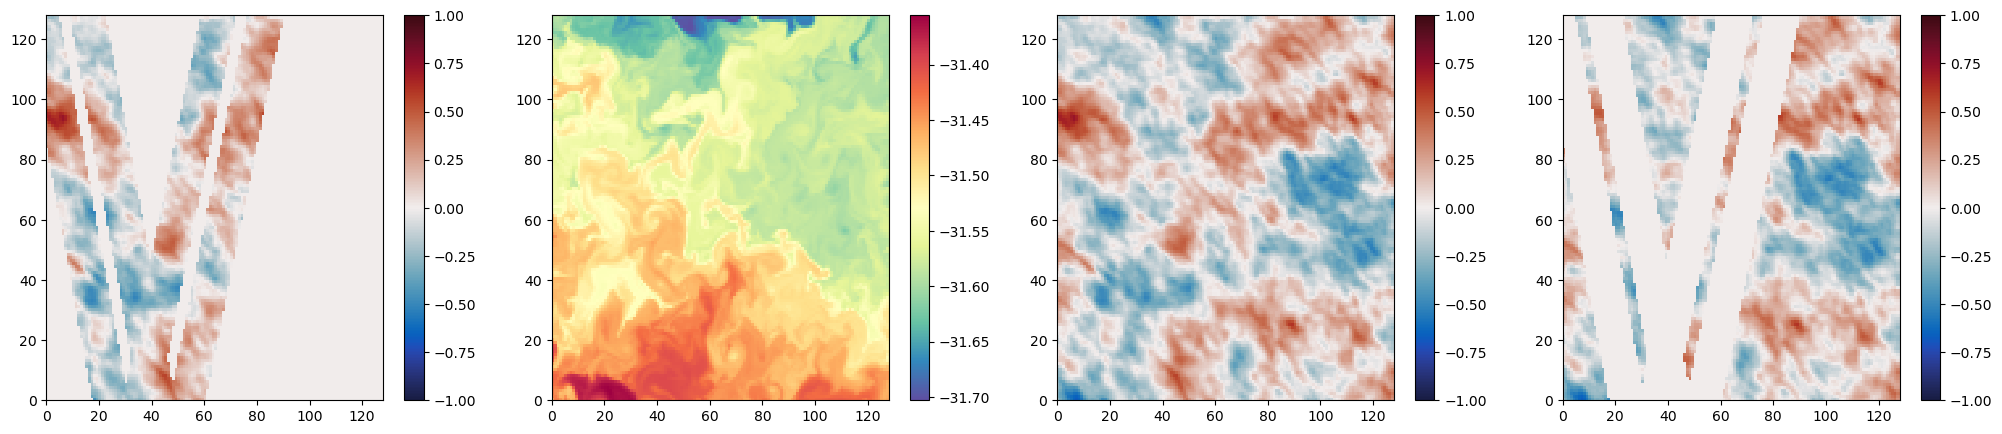

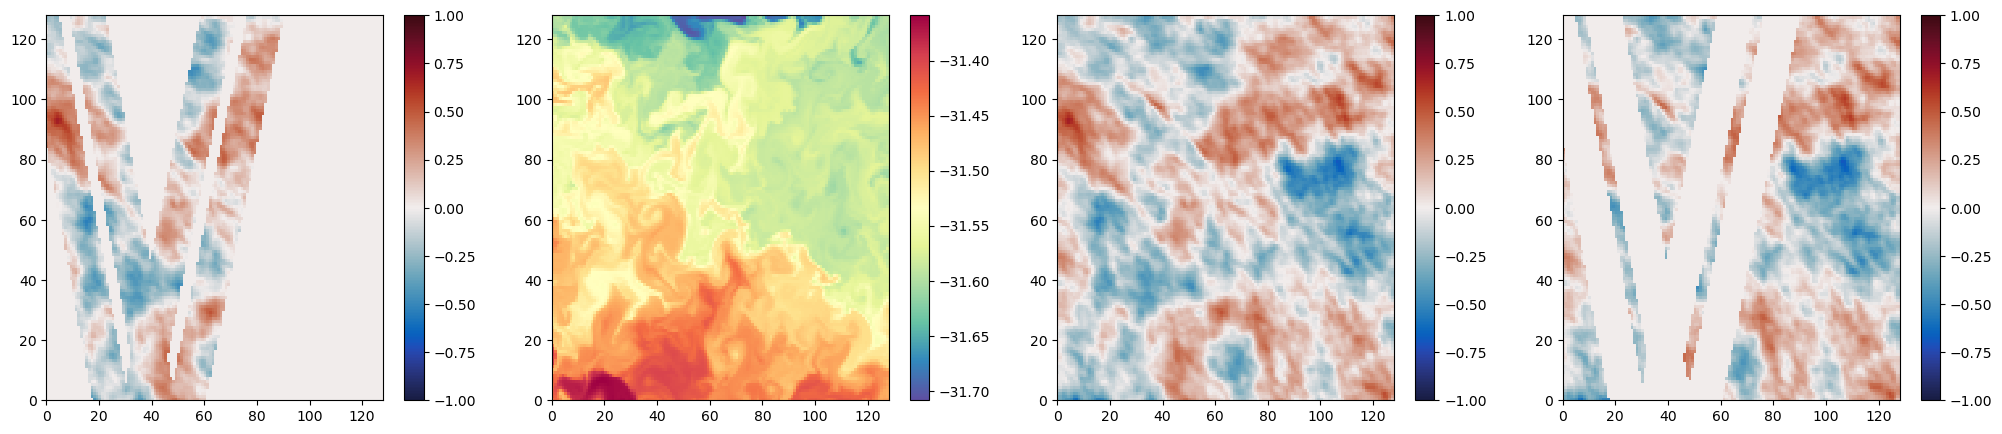

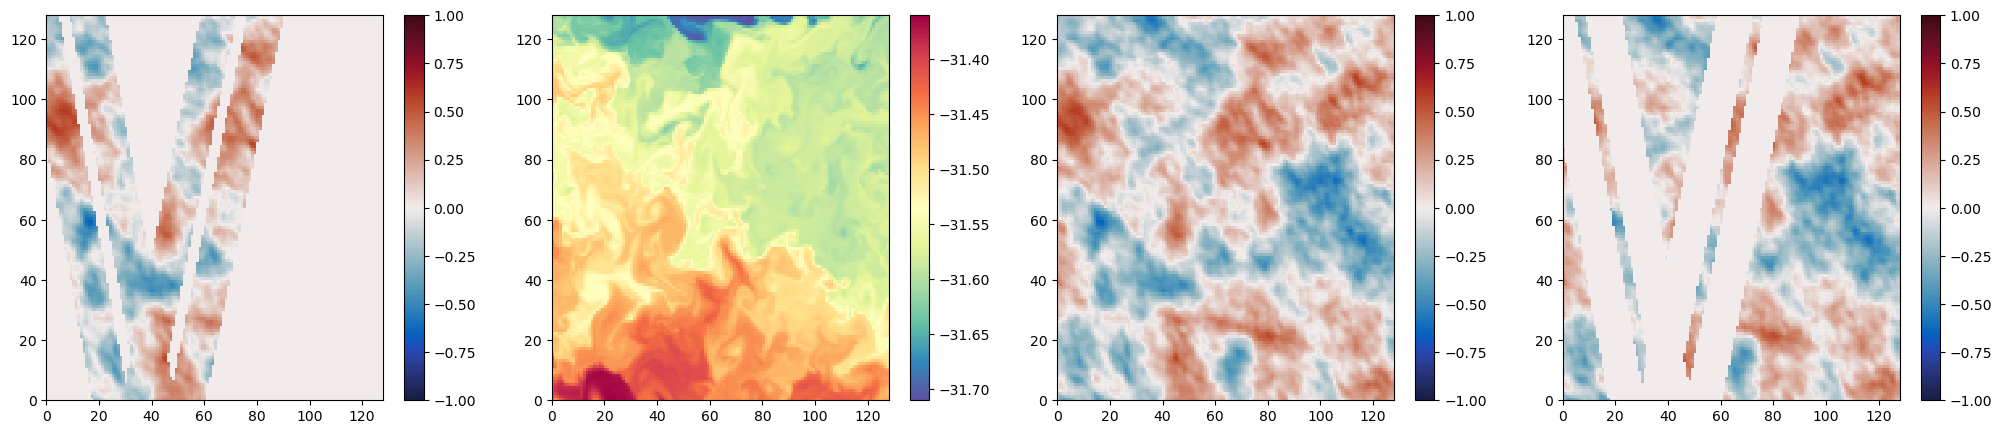

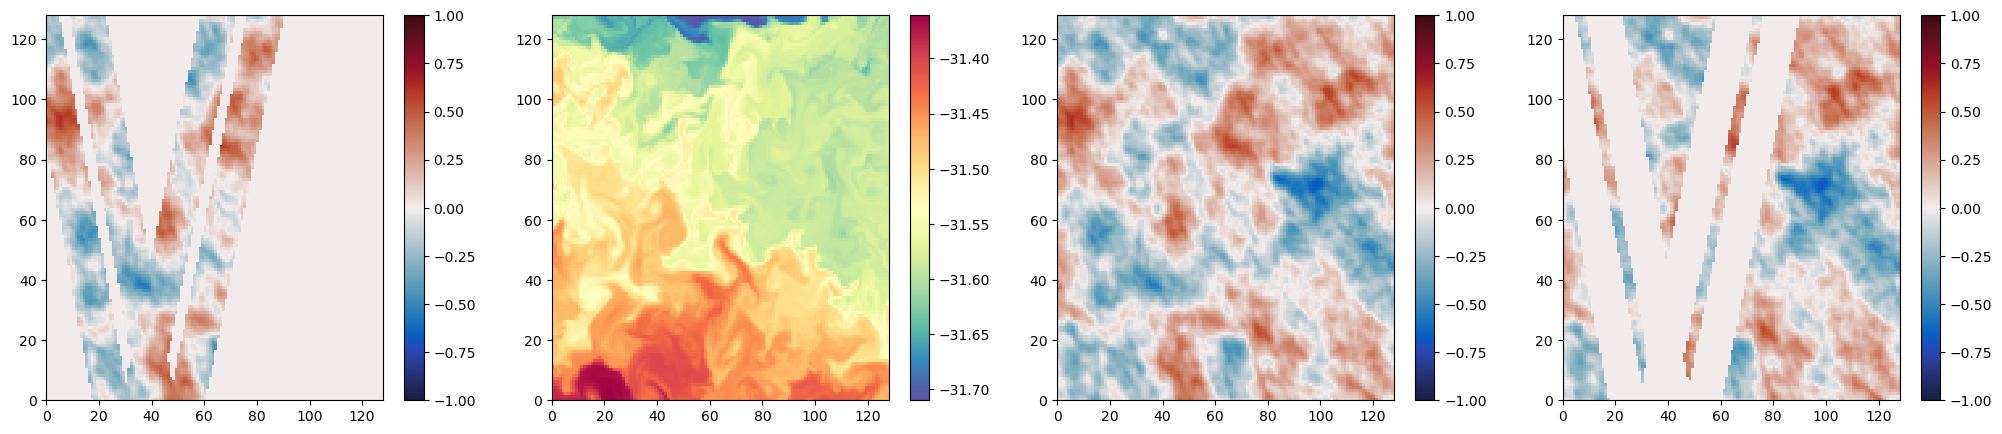

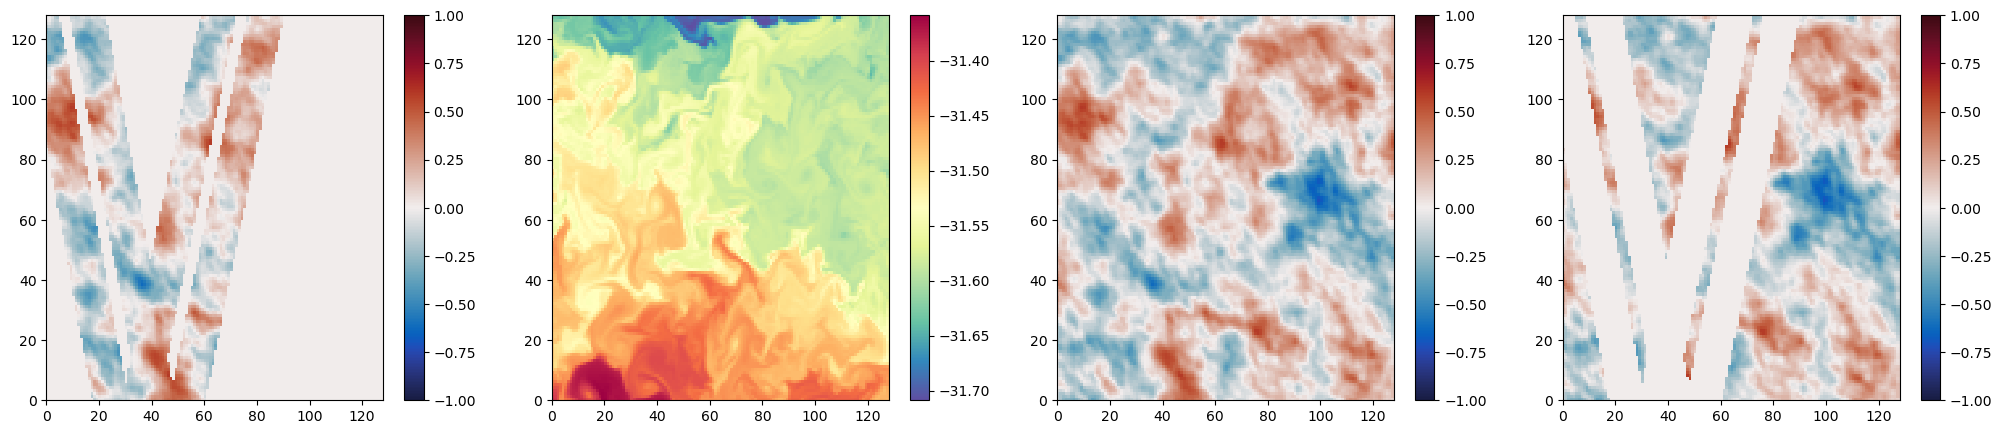

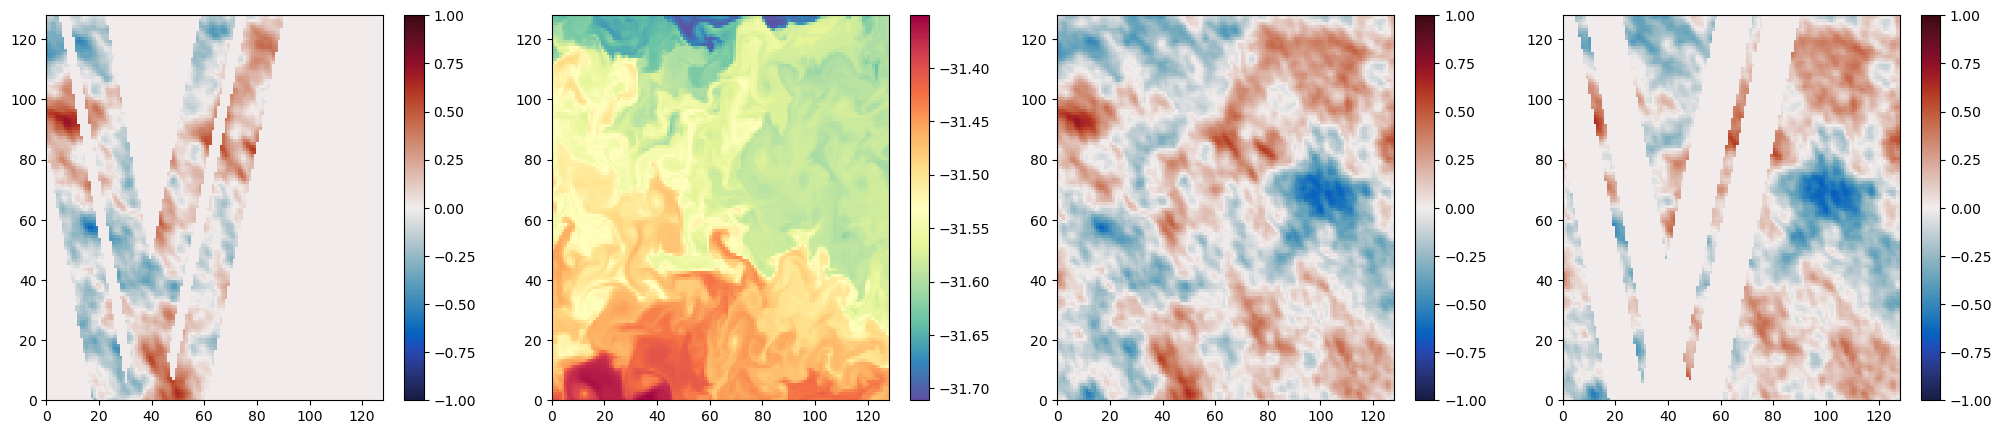

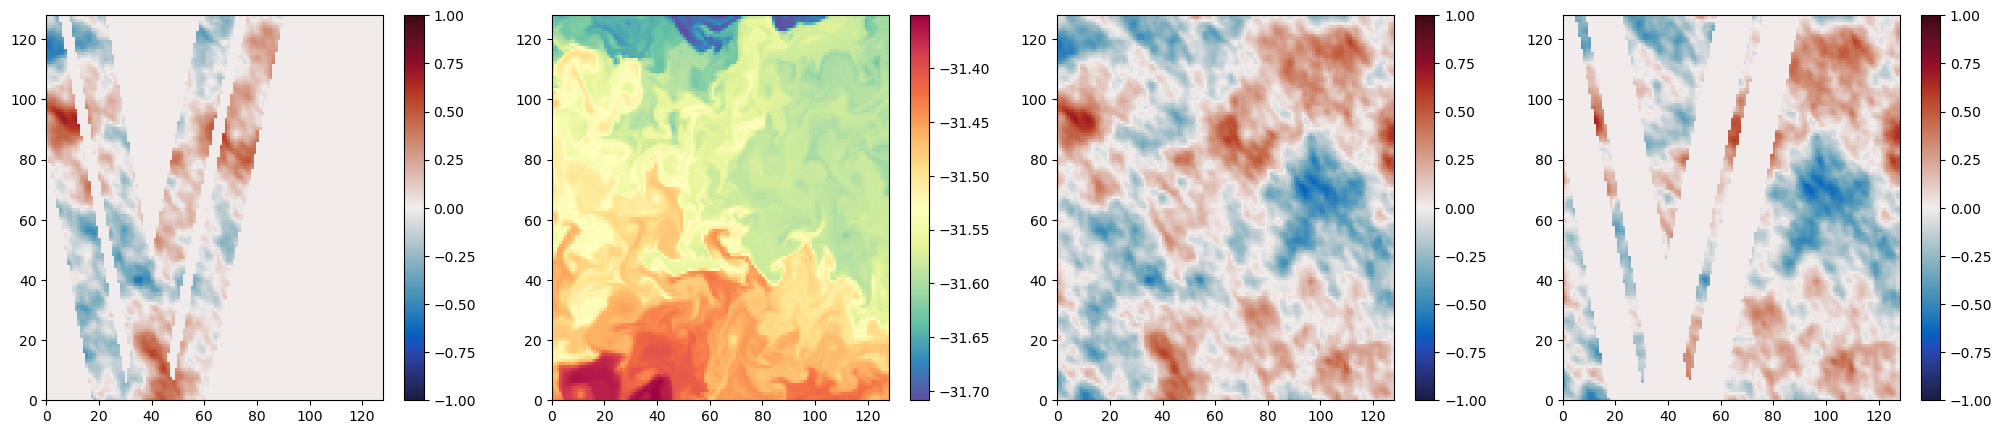

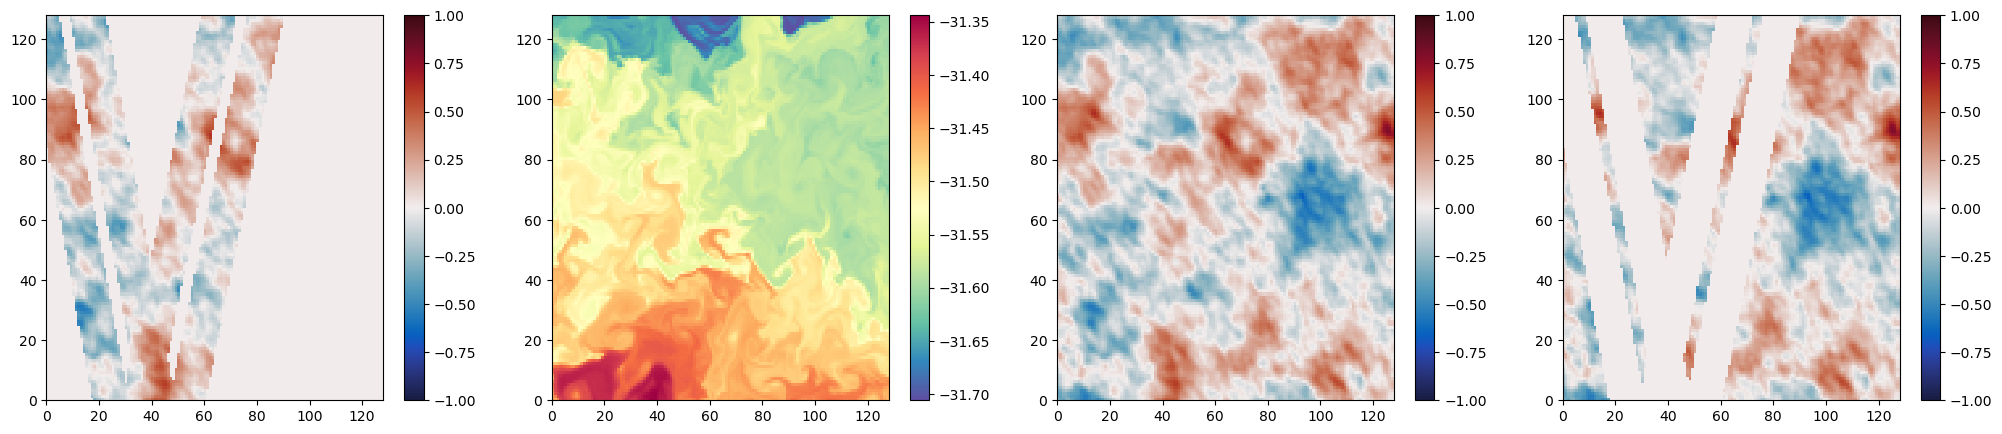

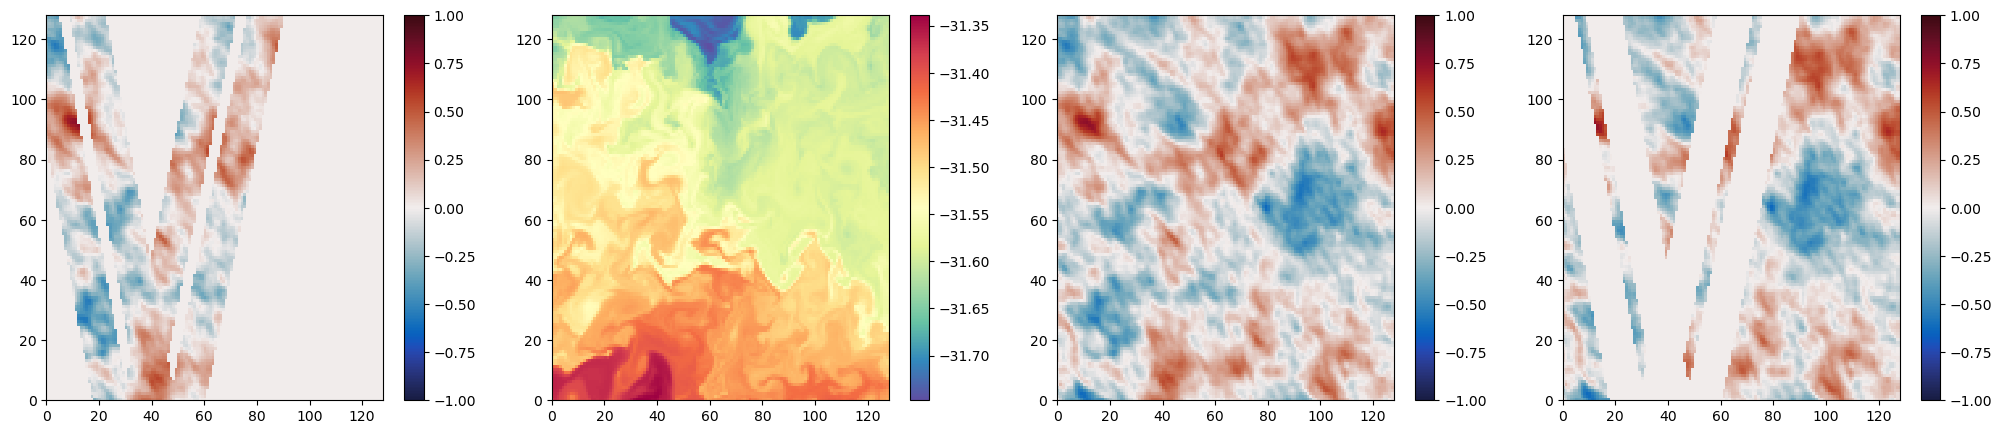

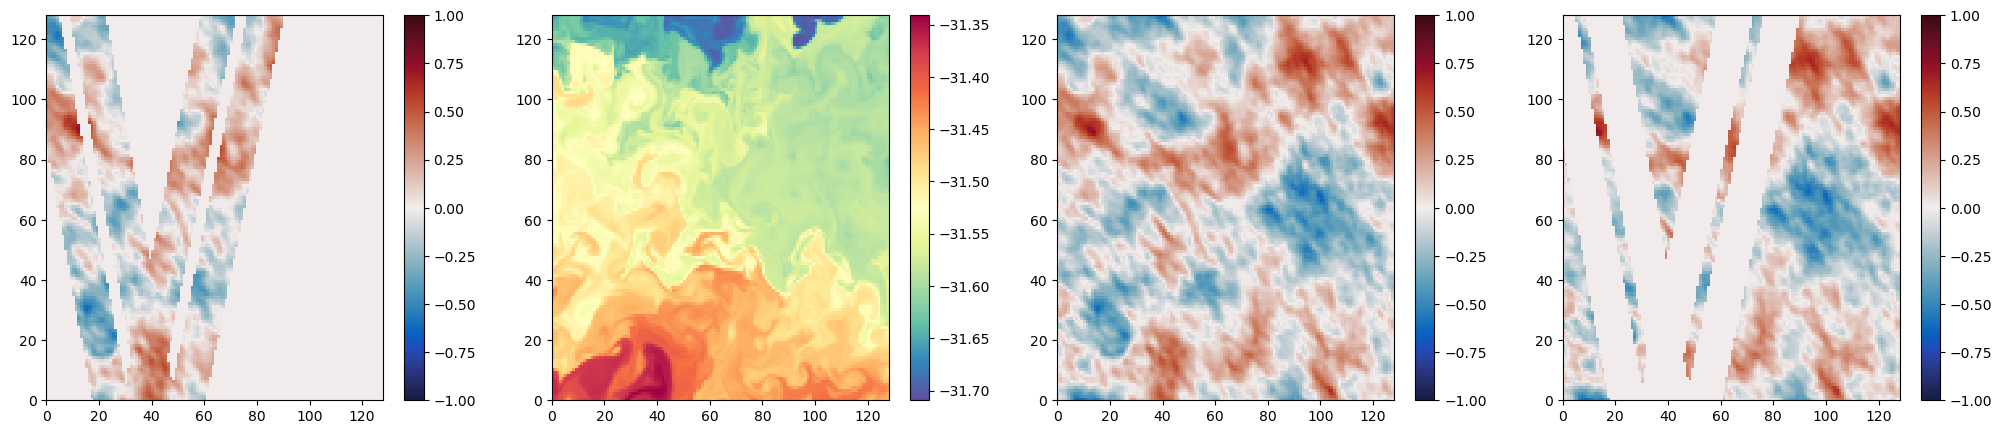

In [15]:
patch_i = 3

for t in range(len(x[patch_i])):
    fig, axs = plt.subplots(1,4,figsize=(25,5))
    ims = [axs[0].pcolor(x[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[1].pcolor(x[patch_i,t,1,:,:],cmap="Spectral_r"),
           axs[2].pcolor(y[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1),
           axs[3].pcolor(y[patch_i,t,0,:,:]-x[patch_i,t,0,:,:],cmap=cm.cm.balance,vmin=-1,vmax=1)]
    for j, im in enumerate(ims):
        fig.colorbar(im,ax=axs[j])
    plt.show()
    plt.close()

# Do some jaxparrow stuff

In [16]:
import jaxparrow
from jaxparrow.tools.kinematics import magnitude

In [17]:
metadata["latitude"].shape

torch.Size([5, 128, 128])

# Calculate geostrophic and cyclstrophic velocities

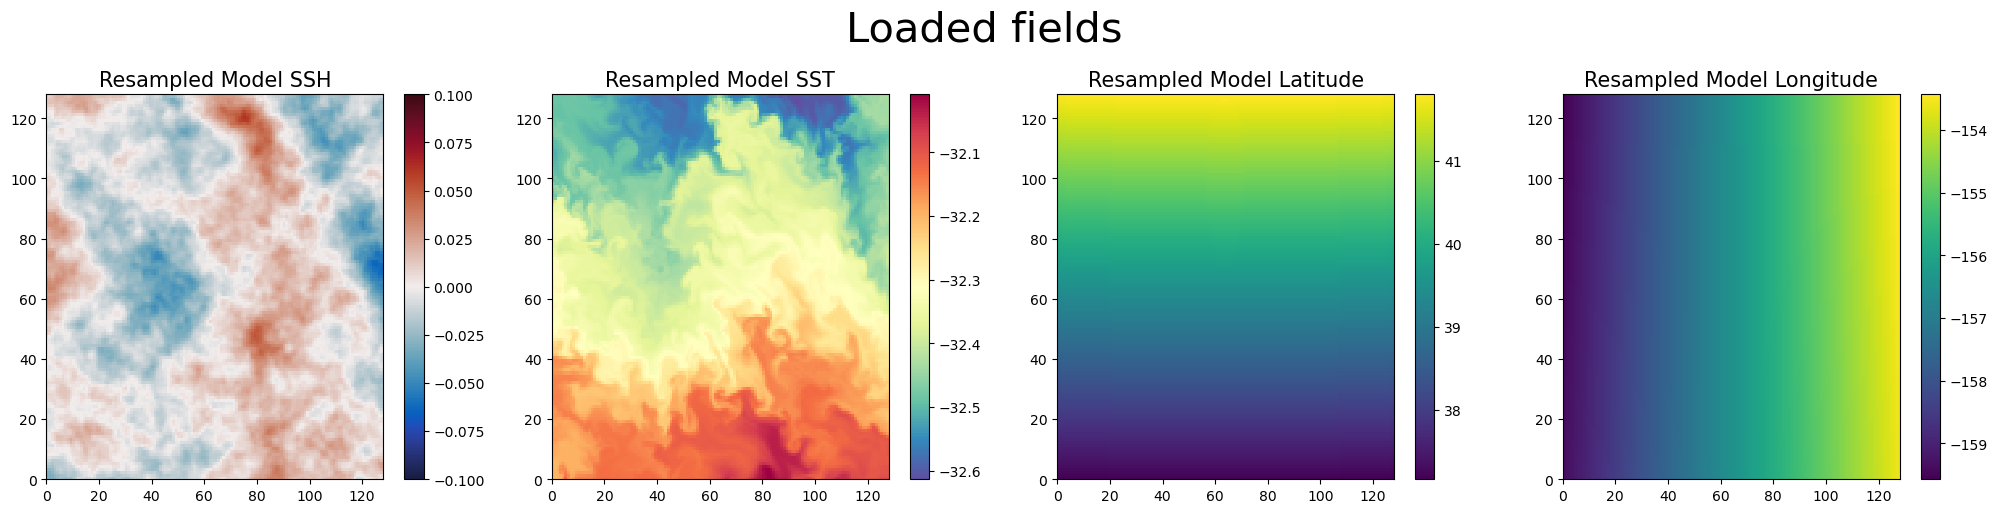

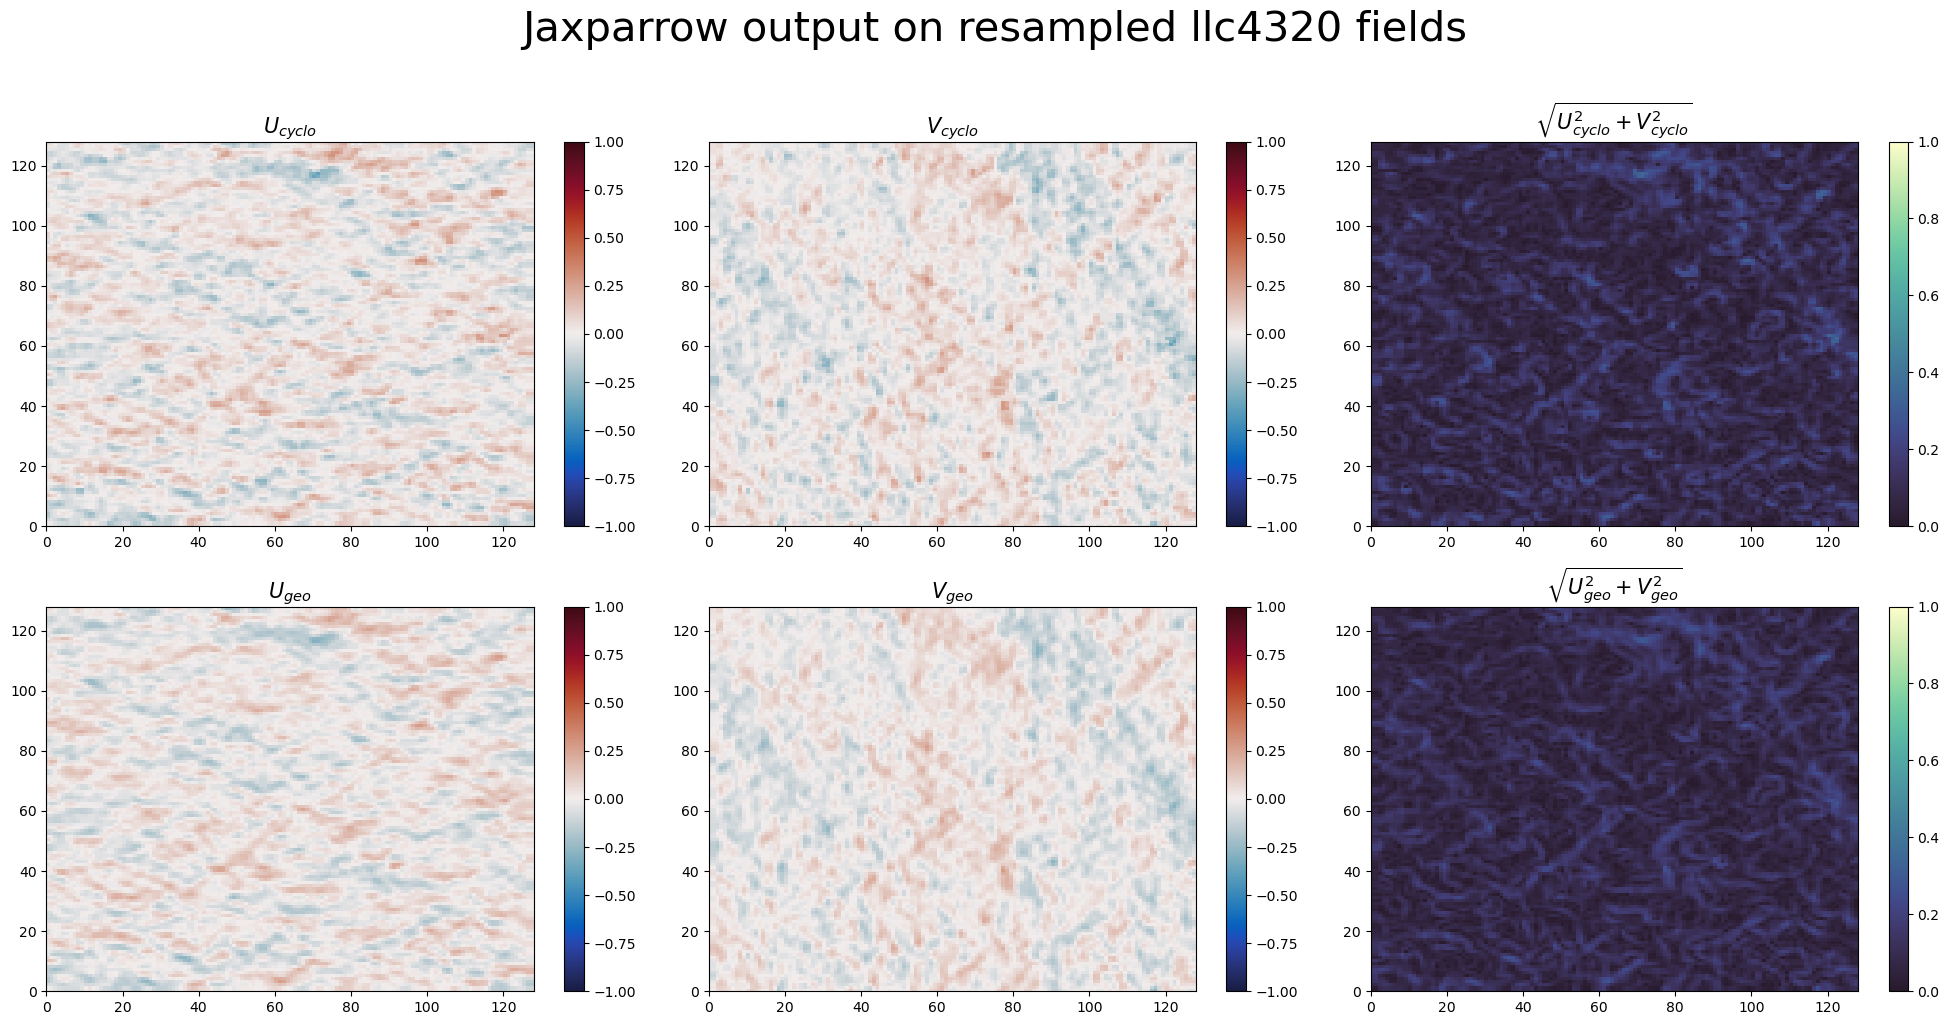

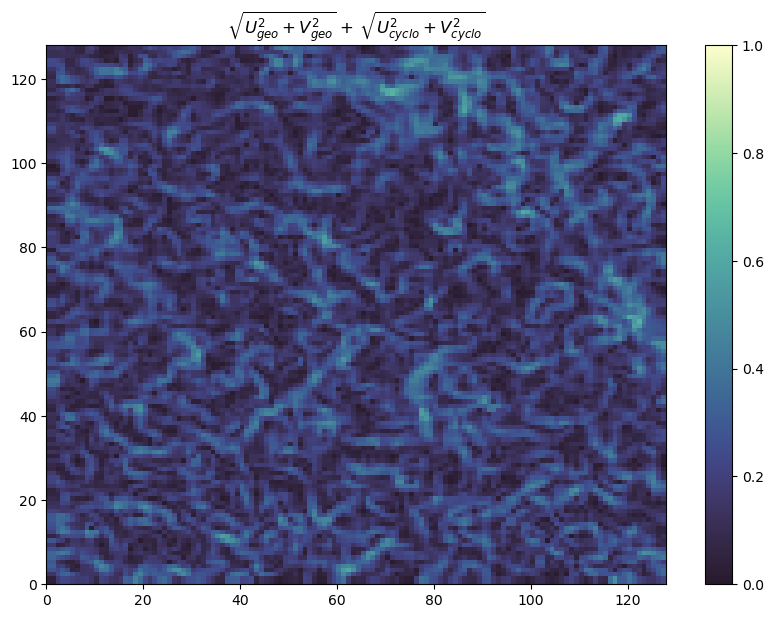

In [40]:
patch_i = 1

sst_in = np.asarray(x[patch_i,t,1,:,:])
ssh_target = np.asarray(y[patch_i,t,0,:,:])*std_ssh
latitude = np.asarray(metadata["latitude"][patch_i])
longitude = np.asarray(metadata["longitude"][patch_i])

cyclo_output = jaxparrow.cyclogeostrophy(ssh_target, latitude, longitude, return_geos=True, return_grids=False)
cyclo_magnitude = magnitude(cyclo_output[0],cyclo_output[1])
geo_magnitude = magnitude(cyclo_output[2],cyclo_output[3])

field_names = ["Resampled Model SSH", "Resampled Model SST", "Resampled Model Latitude", "Resampled Model Longitude"]

fig, axs = plt.subplots(1,4,figsize=(25,5))
ims = [axs[0].pcolor(ssh_target,cmap=cm.cm.balance,vmin=-.1,vmax=.1),
       axs[1].pcolor(sst_in,cmap="Spectral_r"),
       axs[2].pcolor(latitude),
       axs[3].pcolor(longitude)]
for j, im in enumerate(ims):
    axs[j].set_title(field_names[j],fontsize=15)
    fig.colorbar(im,ax=axs[j])
fig.suptitle("Loaded fields",fontsize=30,y=1.05)
plt.show()
plt.close()


field_names = [r"$U_{cyclo}$", r"$V_{cyclo}$",r"$\sqrt{U_{cyclo}^{2} + V_{cyclo}^{2}}$", r"$U_{geo}$", r"$V_{geo}$",r"$\sqrt{U_{geo}^{2} + V_{geo}^{2}}$"]
fig, axs = plt.subplots(2,3,figsize=(20,10))
axs = np.asarray(axs).flatten()

ims = [axs[0].pcolor(cyclo_output[0],vmin=-1.,vmax=1,cmap=cm.cm.balance),
       axs[1].pcolor(cyclo_output[1],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[2].pcolor(cyclo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r),
       axs[3].pcolor(cyclo_output[2],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[4].pcolor(cyclo_output[3],vmin=-1,vmax=1,cmap=cm.cm.balance),
       axs[5].pcolor(geo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r),]

for j, im in enumerate(ims):
    axs[j].set_title(field_names[j],fontsize=15)
    fig.colorbar(im,ax=axs[j])
fig.suptitle("Jaxparrow output on resampled llc4320 fields",fontsize=30,y=1.02)
fig.tight_layout()
plt.show()
plt.close()

fig, axs = plt.subplots(1,1,figsize=(10,7))
im = axs.pcolor(geo_magnitude + cyclo_magnitude,vmin=0,vmax=1,cmap=cm.cm.deep_r)
axs.set_title(r"$\sqrt{U_{geo}^{2} + V_{geo}^{2}}$ + $\sqrt{U_{cyclo}^{2} + V_{cyclo}^{2}}$")
fig.colorbar(im,ax=axs)
plt.show()
plt.close()

# Calculate spectum

# SimVip Encoder